In [260]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time

In [261]:
with open("proj1_data.json") as fp:
    data = json.load(fp)

# Now the data is loaded.
# It a list of data points, where each datapoint is a dictionary with the following attributes:
# popularity_score : a popularity score for this comment (based on the number of upvotes) (type: float)
# children : the number of replies to this comment (type: int)
# text : the text of this comment (type: string)
# controversiality : a score for how "controversial" this comment is (automatically computed by Reddit)
# is_root : if True, then this comment is a direct reply to a post; if False, this is a direct reply to another comment 

In [262]:
# Example:
data_point = data[1009] # select the first data point in the dataset

# Now we print all the information about this datapoint
for name, value in data_point.items():
    print(name + " : " + str(value))

text : "It's days like this that make me wish I'd listened to what my mother always told me when I was a kid."

"Why, what did she say?"

"I don't know. I didn't listen."
is_root : False
controversiality : 0
children : 0
popularity_score : 1.7198436079795936


In [263]:
# Splitting data into partitions

no_data_point = 12000
training_data_points = 10000
validation_data_points = 1000
test_data_points = 1000

train_data = data[ : training_data_points]
validation_data = data[training_data_points : (training_data_points + validation_data_points)]
test_data = data[(training_data_points + validation_data_points) : no_data_point]

print("Number of training data points: " + str(len(train_data)))
print("Number of evaluation data points: " + str(len(validation_data)))
print("Number of test data points: " + str(len(test_data)))

Number of training data points: 10000
Number of evaluation data points: 1000
Number of test data points: 1000


In [264]:
# Weight vector initialization
def weights_init(m, key):
    # key = True => zero initialization
    # key = False => Random initialization
    if key:
        w = np.zeros((m,1))
    else:
        w = np.random.randi(m,1)
    
    return w

In [265]:
# Text pre-processing 

def text_prep(text):
    punctuations_list = '!-[]{};\,<>/"?#$%^&*_~+' + '\n\n'
    output_text = ""
    text = text.strip()
    
    for ch in text:
        if ch not in punctuations_list:
            output_text = output_text + ch
    
    output_text = output_text.lower()
    prep_text = output_text.split(" ")
    prep_text = list(filter(None,prep_text))
    
    return prep_text

In [326]:
# Most-frequent word count features for the whole Training set
def Feature_Matrix(dataset, no_txt_features):
    
    offensive_words_list=['shit','fuck','fucking','bitch','damn','sex','ass','hell',
         'hot','dick','shitty','fucked','asshole','bullshit','gay','porn','crap','sucks']
    
    positive_sentiments_list = ['like', 'really', 'good', 'please', 'love', 'pretty', 'best', 
                                'better', 'great', 'movie', 'happy', 'watching', 'nice', 'fun', 
                                'thanks', 'thank', 'funny', 'cool', 'thankfully', 'super', 'enjoy', 
                                'awesome' , 'wow', 'amazing', 'interesting', 'loved’, ‘liked', 'perfect',
                                'fan', 'glad', 'haha', 'fans', 'hilarious', 'popular', 'fair', 'special', 
                                'beautiful', ':d', ':)', '=d']
    
    negative_sentiments_list = ['bad', 'hate', 'wrong', 'lost', 'damn', 'hell', 'sorry', 'dead', 'weird', 'shitty',
                                'worst', 'terrible', 'worse', 'sad', 'seeing', 'die', 'death', 'died', 'kill', 'poor',
                                'breaking', 'horrible', ':(', '=(']
    
    N = len(dataset)
    All_comments = [None] * N
    Words_Dict = {}
    bias = np.ones((N,1))
    controversiality_vec = np.zeros((N,1))
    is_root_vec = np.zeros((N,1))
    children_vec = np.zeros((N,1))
    Y = np.zeros((N,1))
    X_words_count = np.zeros((N,no_txt_features))
    offensive_count = np.zeros((N,1))
    http_count = np.zeros((N,1))
    positive_sentiments = np.zeros((N,1))
    negative_sentiments = np.zeros((N,1))
    
    for i in range(N):
        for key,val in dataset[i].items():
            if key == 'text':
                preprocessed_text = text_prep(val)
                All_comments[i] = preprocessed_text
                for x in preprocessed_text:
                    if x not in Words_Dict.keys():
                        Words_Dict[x] = 0
                    Words_Dict[x] += 1
            
            elif key == 'is_root':
                if val:
                    is_root_vec[i] = 1
                else:
                    is_root_vec[i] = 0

            elif key == 'controversiality':
                controversiality_vec[i] = val
            
            elif key == 'children':
                children_vec[i] = val
            
            elif key == 'popularity_score':
                Y[i] = val

# Now we need to sort out from most-frequent to least-frequent words in dictionary to obtain the first N words
    if no_txt_features == 0 :
        
        X1 = np.append(children_vec,controversiality_vec,axis=1)
        X1 = np.append(X1,is_root_vec,axis=1)        
        X = np.append(X1,bias,axis=1)
        
    else:
        Words_Dict_Sorted = sorted(Words_Dict.items(), key = lambda t: t[1], reverse=True)
        Most_Freq_Words_Dict = dict(list(Words_Dict_Sorted[:no_txt_features]))
        Most_Freq_Words = list(Most_Freq_Words_Dict.keys())
        
# Now we need to count the frequency of most frequent words in each comment throughout the whole dataset
                
        # Most-Frequent words
        for i in range(N):
            for j in range(no_txt_features):  
                X_words_count[i,j] = All_comments[i].count(Most_Freq_Words[j])     
        
        # Offensive and HTTP-containing comments
        
        for i in range(N):
            for x in All_comments[i]:
                if x.find('http') or x.find('www.') != -1 :
                    http_count[i] = 1
                
                for l in range(len(positive_sentiments_list)):
                    if x.find(positive_sentiments_list[l]) != -1 :
                        positive_sentiments[i] += 1
                
                for l in range(len(negative_sentiments_list)):
                    if x.find(negative_sentiments_list[l]) != -1 :
                        negative_sentiments[i] += 1
                        
            for j in range(len(offensive_words_list)):  
                offensive_count[i] += All_comments[i].count(offensive_words_list[j])
            
        for j in range(len(offensive_words_list)):  
            if offensive_count[i] > 0:
                offensive_count[i] = 1
        
        
        # Positive or negative sentiments
        
        X1 = np.append(X_words_count,controversiality_vec,axis=1)
        X1 = np.append(X1,is_root_vec,axis=1)
        X1 = np.append(X1,children_vec,axis=1)
        X1 = np.append(X1,offensive_count,axis=1)
        X1 = np.append(X1,http_count,axis=1)
        X1 = np.append(X1,positive_sentiments,axis=1)
        X1 = np.append(X1,negative_sentiments,axis=1)
        
        # Data Rescaling
        
        for i in range(X1.shape[1]):
            mean = np.mean(X1[:,i])
            var = np.var(X1[:,i])
            X1[:,i] = (1 / np.sqrt(var)) * (X1[:,i] - mean)
        
        X = np.append(X1,bias,axis=1)       
        
    return X, Y, Most_Freq_Words_Dict

In [267]:
# Least-Square estimation

def Least_Squares_Estimation(X,Y):
    X_T = (X.T).dot(X)
    X_T_inv = np.linalg.inv(X_T)
    X_Y = (X.T).dot(Y)
    w_hat = np.dot(X_T_inv, X_Y)

    return w_hat

In [268]:
# Gradient Descent
def Gradient_Descent(X, Y, W0, B, E, eps):
    
    eta0 = E
    beta = B
    epsilon = eps
    w0 = W0
    mse = np.zeros(100000000) # some big number for number of epochs
    X_T = np.dot(X.T, X)
    X_Y = np.dot(X.T, Y)
    alpha = eta0 / ( 1 + beta )
    w_gd = w0 - 2 * alpha * (np.subtract(np.dot(X_T,w0), X_Y))
    diff = np.linalg.norm(np.subtract(w_gd,w0))
    epoch = 0
    mse[epoch] = Mean_Square_Error(X, Y, w_gd)
    
    while diff > epsilon:
        w0 = w_gd
        alpha =  eta0 / (1 + beta * (epoch + 1))
        w_gd = w0 - 2 * alpha * np.subtract((X_T).dot(w0), X_Y)
        diff = np.linalg.norm(np.subtract(w_gd, w0))
        epoch +=1
        mse[epoch] = Mean_Square_Error(X, Y, w_gd)
    
    MSE = np.delete(mse, np.s_[epoch + 1 : len(mse) + 1]) # Removing zero-valued MSE at the end
    
    return w_gd, MSE

In [269]:
# MSE
def Mean_Square_Error(X, Y, w_hat):
    prediction = np.dot(X,w_hat)
    abs_err = np.subtract(Y,prediction)
    squared_err = np.square(abs_err)
    MSE = (1/X.shape[0]) * np.sum(squared_err)  
    return MSE

In [270]:
# Visualisations
def lineplot(x_data, y_data, x_label="", y_label="", title="", gcolor=""):
    # Create the plot object    
    
    # Plot the best fit line, set the linewidth (lw), color and
    # transparency (alpha) of the line
    plt.plot(x_data, y_data, lw = 2, color = gcolor, alpha = 1)
    
    # Label the axes and provide a title
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    

In [327]:
# Performance Evaluation
no_text_features = 160
Eta0 = 1e-6
Beta0 = 0.0001
epsilon = 1e-6
X,Y,most_freq_words = Feature_Matrix(train_data, no_text_features)
W0 = weights_init(X.shape[1], True) # All_zero weights initialization if True

start1 = time.time()
W_LS = Least_Squares_Estimation(X, Y)
MSE_LS_training = Mean_Square_Error(X, Y, W_LS)
end1 = time.time()

print("MSE for LS on Training set is: " + str(MSE_LS_training) + " which took: " + str((end1-start1) * 1000) + " ms" + "")

start2 = time.time()
W_GD, MSE_GD_training = Gradient_Descent(X, Y, W0, Beta0, Eta0, epsilon)
end2 = time.time()
print("Final MSE for GD on Training set at " + str(len(MSE_GD_training)) + "'s epoch is :" + str(MSE_GD_training[-1]) +
     " which took: " + str((end2-start2) * 1000) + " ms" + "")


# Run on Validation dataset

X_validation, Y_validation, _ = Feature_Matrix(validation_data, no_text_features)

MSE_LS_validation = Mean_Square_Error(X_validation, Y_validation, W_LS)

print("MSE for LS on Validation set is: " + str(MSE_LS_validation))

MSE_GD_validation = Mean_Square_Error(X_validation, Y_validation, W_GD)

print("Final MSE for GD on Validation set is :" + str(MSE_GD_validation))


MSE for LS on Training set is: 1.0452516646873893 which took: 13.970136642456055 ms
Final MSE for GD on Training set at 4402's epoch is :1.0452517672030792 which took: 2437.9935264587402 ms
MSE for LS on Validation set is: 1.036421488915833
Final MSE for GD on Validation set is :1.0363143038778946


In [328]:
print(most_freq_words)

{'the': 9250, 'i': 6132, 'a': 5914, 'to': 5880, 'and': 5664, 'of': 4101, 'that': 3073, 'you': 3050, 'it': 3035, 'in': 2922, 'is': 2380, 'was': 2377, 'my': 2264, 'for': 2019, 'have': 1675, 'but': 1635, 'this': 1550, 'with': 1485, 'on': 1418, 'not': 1361, 'be': 1251, 'just': 1215, 'or': 1195, 'so': 1165, 'they': 1160, 'like': 1151, 'if': 1137, 'your': 1135, 'me': 1112, 'are': 1051, 'at': 1020, 'as': 963, 'he': 955, "it's": 864, 'about': 839, 'she': 831, "i'm": 823, 'all': 819, 'when': 802, 'we': 794, 'out': 794, 'her': 784, 'because': 771, 'from': 750, 'would': 738, 'get': 731, "don't": 725, 'up': 723, 'what': 719, 'one': 713, 'had': 703, 'people': 697, 'do': 668, 'can': 666, 'an': 643, 'deleted': 626, 'there': 606, 'no': 544, 'some': 536, 'really': 533, 'any': 524, 'how': 511, 'his': 497, 'then': 495, 'think': 477, 'more': 470, 'them': 465, 'time': 455, 'go': 453, 'their': 449, 'were': 444, 'who': 440, 'will': 435, 'know': 427, 'by': 413, 'has': 407, 'only': 397, 'good': 390, 'new': 382

In [235]:
# Performance Evaluation for a range of number_of_features in order to identify best model

number_text_features = np.arange(0,161)
Eta0 = 1e-6
Beta0 = 0.0001
epsilon = 1e-6
result_train = np.zeros((len(number_text_features),2))
result_valid = np.zeros((len(number_text_features),2))


for i in range(len(number_text_features)):
    no_text_features = number_text_features[i]
    print("Number of text features: " + str(no_text_features))
    X,Y,_ = Feature_Matrix(train_data, no_text_features)
    W0 = weights_init(X.shape[1], True) # All_zero weights initialization if True

    start1 = time.time()
    W_LS = Least_Squares_Estimation(X, Y)
    MSE_LS_training = Mean_Square_Error(X, Y, W_LS)
    end1 = time.time()
    print("MSE for LS on Training set is: " + str(MSE_LS_training) + " which took: " + str((end1-start1) * 1000) + " ms" + "")

    start2 = time.time()
    W_GD, MSE_GD_training = Gradient_Descent(X, Y, W0, Beta0, Eta0, epsilon)
    end2 = time.time()
    print("Final MSE for GD on Training set at " + str(len(MSE_GD_training)) + "'s epoch is :" + str(MSE_GD_training[-1]) +
         " which took: " + str((end2-start2) * 1000) + " ms" + "")
    print(" ")
    result_train[i,0] = MSE_LS_training
    result_train[i,1] = MSE_GD_training[-1]

    # Run on Validation dataset
    X_validation, Y_validation,_ = Feature_Matrix(validation_data, no_text_features)

    MSE_LS_validation = Mean_Square_Error(X_validation, Y_validation, W_LS)

    print("MSE for LS on Validation set is: " + str(MSE_LS_validation))

    MSE_GD_validation = Mean_Square_Error(X_validation, Y_validation, W_GD)

    print("Final MSE for GD on Validation set is :" + str(MSE_GD_validation))
    print(" ")

    result_valid[i,0] = MSE_LS_validation
    result_valid[i,1] = MSE_GD_validation

Number of text features: 0
MSE for LS on Training set is: 1.0846830709157251 which took: 0.0 ms
Final MSE for GD on Training set at 43323's epoch is :1.0846892312314529 which took: 2132.9681873321533 ms
 
MSE for LS on Validation set is: 1.020326684843145
Final MSE for GD on Validation set is :1.0204268695519987
 
Number of text features: 1


KeyboardInterrupt: 

In [311]:
# Run on Test dataset

# no_text_features = 0
X_test, Y_test,_ = Feature_Matrix(test_data, no_text_features)

MSE_LS_Test = Mean_Square_Error(X_test, Y_test, W_LS)

print("MSE for LS on Test set is: " + str(MSE_LS_Test))

MSE_GD_validation = Mean_Square_Error(X_test, Y_test, W_GD)

print("MSE for GD on Test set is :" + str(MSE_GD_validation))

MSE for LS on Test set is: 1.2707377671901572
MSE for GD on Test set is :1.2707013325581547


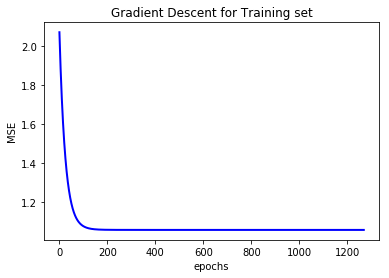

In [306]:

lineplot(range(MSE_GD_training.shape[0]), MSE_GD_training, 
         x_label="epochs", y_label="MSE", title="Gradient Descent for Training set", gcolor='b')
# lineplot(range(MSE_GD_training.shape[0]), MSE_GD_validation, 
#          x_label="epochs", y_label="MSE", title="Gradient Descent", gcolor='r')
